In [ ]:
import pandas as pd

In [ ]:
!pip install pandas google-cloud-bigquery

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import pandas as pd
from google.cloud import bigquery


project_id = 'saja-challenge-1-sql'
dataset_id = 'saja-challenge-1-sql.jobteaser'
query = 'select* from saja-challenge-1-sql.Jobteaser.candidate_status_update'
query2 = 'select* from saja-challenge-1-sql.Jobteaser.dim_schools'
query3 = 'select* from saja-challenge-1-sql.CLean.optin_375'

client = bigquery.Client(project=project_id)
candidate = client.query(query).to_dataframe()
schools = client.query(query2).to_dataframe()
optin = client.query(query3).to_dataframe()


In [ ]:
candidate.shape

(50395, 7)

In [ ]:
schools.shape

(3938, 6)

In [ ]:
optin.shape

(375473, 8)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer


In [ ]:
# Merge data on 'school_id' to include school info in the optin data
data = pd.merge(optin, schools, on='school_id', how='left')

# Fill missing values
imputer = SimpleImputer(strategy='most_frequent')
data[['current_sign_in_at']] = imputer.fit_transform(data[['current_sign_in_at']])

# Convert date to datetime and extract relevant features
data['current_sign_in_at'] = pd.to_datetime(data['current_sign_in_at'])
data['day_of_week'] = data['current_sign_in_at'].dt.dayofweek
data['hour_of_day'] = data['current_sign_in_at'].dt.hour

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ['cause', 'jt_country', 'jt_intranet_status', 'is_cc']  # Add other necessary columns
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))

# Convert boolean 'active' to integer
data['active'] = data['active'].astype(int)

# Drop unnecessary columns
data.drop(['user_id', 'school_id', 'intranet_school_id', 'receive_time', 'current_sign_in_at'], axis=1, inplace=True)

data

,cause,active,resume_uploaded,rn,is_cc,jt_country,jt_intranet_status,jt_school_type,day_of_week,hour_of_day
0,1,1,True,1,2,21,1,2,6,13
1,1,1,True,1,2,14,1,2,0,13
2,1,1,True,1,2,7,1,1,1,15
3,1,1,True,1,2,21,1,2,1,13
4,1,1,True,1,2,7,1,2,4,12
...,...,...,...,...,...,...,...,...,...,...
375468,1,1,True,1,2,25,1,3,3,1
375469,1,1,True,1,2,7,1,1,2,8
375470,1,1,True,1,2,7,1,2,1,9
375471,1,0,True,1,2,25,1,3,4,14


In [ ]:
data.isnull().sum()

cause                 0
active                0
resume_uploaded       0
rn                    0
is_cc                 0
jt_country            0
jt_intranet_status    0
jt_school_type        5
day_of_week           0
hour_of_day           0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

cause                 0
active                0
resume_uploaded       0
rn                    0
is_cc                 0
jt_country            0
jt_intranet_status    0
jt_school_type        0
day_of_week           0
hour_of_day           0
dtype: int64

In [ ]:
# Define features and target
X = data.drop('resume_uploaded', axis=1)
y = data['resume_uploaded'].astype(int)  # Ensure target is integer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(300374, 9)
(75094, 9)
(300374,)
(75094,)


In [ ]:
# Initialize and train the RandomForest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Print model accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7860548113031667
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.11      0.18     15749
           1       0.80      0.97      0.88     59345

    accuracy                           0.79     75094
   macro avg       0.63      0.54      0.53     75094
weighted avg       0.73      0.79      0.73     75094



In [ ]:
from sklearn.linear_model import LogisticRegression

# Create logistic regression model
logreg = LogisticRegression()

# Fit model
logreg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))


Accuracy: 0.7904226702532825
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.01      0.03     15749
           1       0.79      1.00      0.88     59345

    accuracy                           0.79     75094
   macro avg       0.65      0.51      0.46     75094
weighted avg       0.73      0.79      0.70     75094



In [ ]:
logreg.coef_

array([[-6.87334702e-02,  1.97472228e-01,  0.00000000e+00,
        -1.08204228e-01, -2.11333814e-01, -5.59314560e-02,
        -3.18218735e-01, -1.02340491e-05, -1.29167182e-02]])

In [ ]:
logreg.intercept_

array([1.37962693])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)


In [ ]:
# Create a DataFrame to view the coefficients linked to each feature
coef_df = pd.DataFrame(logreg.coef_[0], X_train_scaled_df.columns, columns=['Coefficients'])

# Display the DataFrame sorted by absolute values of coefficients in descending order
coef_df['Absolute Coefficients'] = coef_df['Coefficients'].abs()
coef_df.sort_values(by='Absolute Coefficients', ascending=False)


,Coefficients,Absolute Coefficients
jt_school_type,-0.318219,0.318219
jt_country,-0.211334,0.211334
active,0.197472,0.197472
is_cc,-0.108204,0.108204
cause,-0.068733,0.068733
jt_intranet_status,-0.055931,0.055931
hour_of_day,-0.012917,0.012917
day_of_week,-0.000010,0.000010
rn,0.000000,0.000000


Accuracy: 0.7931259488108238
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.04      0.07     15749
           1       0.80      0.99      0.88     59345

    accuracy                           0.79     75094
   macro avg       0.71      0.52      0.48     75094
weighted avg       0.76      0.79      0.71     75094

Feature Importance:
 [2.19713487e-04 8.51641057e-02 0.00000000e+00 2.30420871e-02
 3.24846556e-01 1.24669866e-02 5.45527454e-01 1.41854360e-03
 7.31455281e-03]


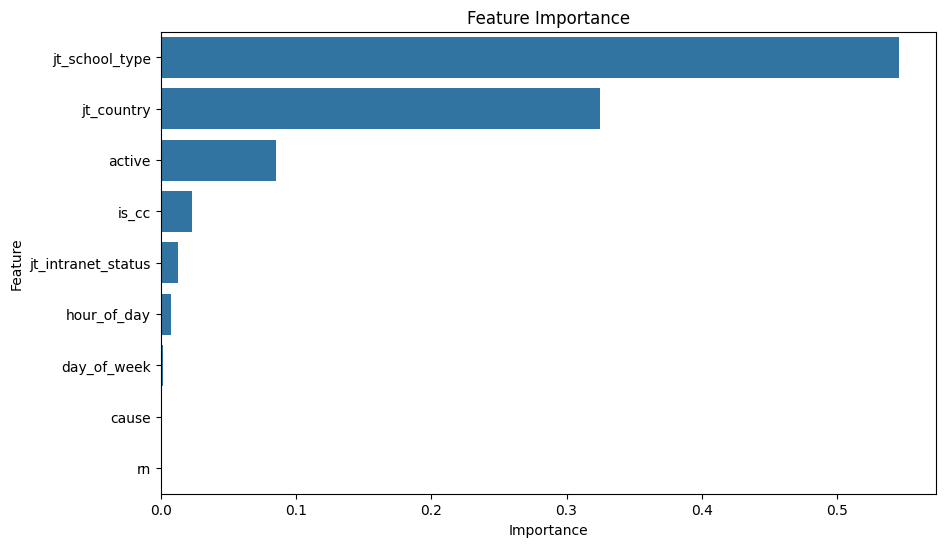

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Assuming X and y are already defined and hold your feature set and target variable respectively
# Here's a quick mock of these for the context, replace with your actual data loading steps
# X, y = load_your_data_function()  # This is a placeholder, replace with actual data loading

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Gradient Boosting Classifier model
gbc = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
gbc.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gbc = gbc.predict(X_test_scaled)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))

# Extract and print feature importance
feature_importance = gbc.feature_importances_
print("Feature Importance:\n", feature_importance)

# Optionally, create a more readable format by attaching feature names and sorting them
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=features_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()


In [ ]:
features_df

,Feature,Importance
6,jt_school_type,0.545527
4,jt_country,0.324847
1,active,0.085164
3,is_cc,0.023042
5,jt_intranet_status,0.012467
8,hour_of_day,0.007315
7,day_of_week,0.001419
0,cause,0.000220
2,rn,0.000000


In [ ]:
from sklearn.svm import SVC

# Create SVM model
svm = SVC()

# Fit model
svm.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Create Gradient Boosting model
gbc = GradientBoostingClassifier()

# Fit model
gbc.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gbc = gbc.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))


Accuracy: 0.7931259488108238
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.04      0.07     15749
           1       0.80      0.99      0.88     59345

    accuracy                           0.79     75094
   macro avg       0.71      0.52      0.48     75094
weighted avg       0.76      0.79      0.71     75094



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit model
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


Accuracy: 0.76895624151064
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.20      0.27     15749
           1       0.81      0.92      0.86     59345

    accuracy                           0.77     75094
   macro avg       0.61      0.56      0.56     75094
weighted avg       0.73      0.77      0.74     75094



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)


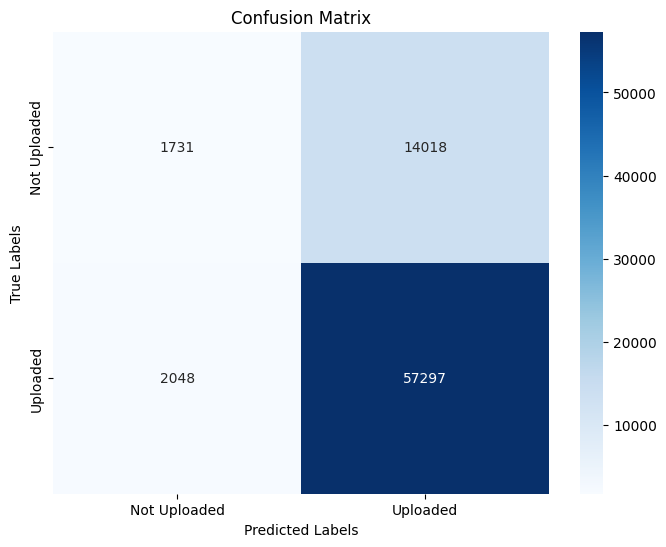

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Uploaded', 'Uploaded'], yticklabels=['Not Uploaded', 'Uploaded'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


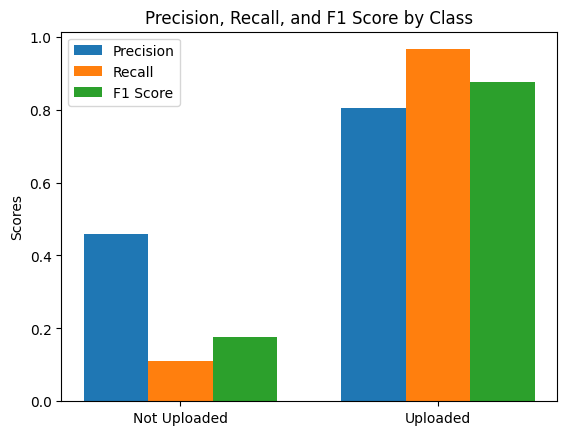

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Extracting precision, recall, and F1 scores
scores = precision_recall_fscore_support(y_test, y_pred)
precision = scores[0]
recall = scores[1]
f1 = scores[2]

# Creating a bar chart
labels = ['Not Uploaded', 'Uploaded']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
